In [20]:
%matplotlib inline
%config InlineBackend.figure_format = True
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.utils.console import ProgressBar
import astropy.units as u

import sys
sys.path.insert(0, '../')
from mrspoc import Star, Spot

The sizes of spots on superflare stars can be estimated from their rotational modulation (see superflare papers by Maehara, Notsu and collaborators). The superflare stars with the largest rotational modulation could be attributed to spots as large as 10% of the observer-facing stellar hemisphere. We convert that spot area to a spot radius for a cicular spot with: 

$$ R_{spot} / R_\star = \sqrt{2 A_{hem}} $$

where $A_{hem}$ is the spot area in units of hemispheres. 

superflare spot radius: 0.6324555320336759


../mrspoc/star.py:280: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - r**2)


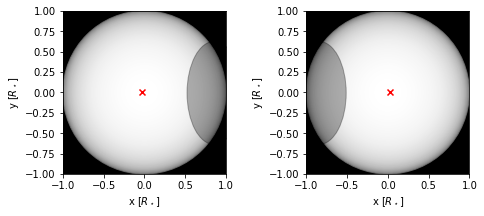

In [21]:
area = 0.2
spot_radius = np.sqrt(2 * area)

print('superflare spot radius: {}'.format(spot_radius))

superflare_t0 = Star()
superflare_t0.spots = [Spot(x=0.85, y=0.00, r=spot_radius)]

superflare_t1 = Star()
superflare_t1.spots = [Spot(x=-0.85, y=0.00, r=spot_radius)]

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
superflare_t0.plot(col=True, ax=ax[0])
superflare_t1.plot(col=True, ax=ax[1])

In [22]:
photocenters = []

# Measure photocenters as the star rotates
for x in np.linspace(-0.8, 0.8, 50):
    superflare = Star()
    superflare.spots = [Spot(x=x, y=0.00, r=spot_radius)]
    
    photocenters.append(superflare.center_of_light)
    
# Measure photocenters as the spot is on the back-side of the star

for x in range(50):
    photocenters.append([0, 0])
    
photocenters = np.array(photocenters)

r_vector = np.sqrt(photocenters[:, 0]**2 + photocenters[:, 1]**2)
max_photocenter_shift = np.max(r_vector)
max_photocenter_shift

../mrspoc/star.py:280: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - r**2)


0.053834303069298754

(array([ 52.,   2.,   2.,   2.,   4.,   2.,   4.,   8.,   6.,  18.]),
 array([ 0.        ,  0.00538343,  0.01076686,  0.01615029,  0.02153372,
         0.02691715,  0.03230058,  0.03768401,  0.04306744,  0.04845087,
         0.0538343 ]),
 <a list of 10 Patch objects>)

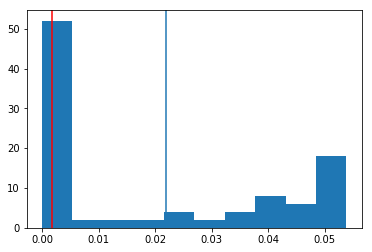

In [23]:
from astropy.stats import mad_std
plt.axvline(np.std(r_vector))
plt.axvline(mad_std(r_vector), color='r')

plt.hist(r_vector)
#plt.xlabel('Jitter [$\mu$AU]')

In [24]:
from mrspoc.tgas import bv_to_radius
R_superflare = bv_to_radius(14.47-12.83)
print('Jitter [$\mu$AU] = {}'.format((R_superflare * max_photocenter_shift).to(u.uAU)))

Jitter [$\mu$AU] = 96.0779885008745 uAU


../mrspoc/tgas.py:85: RuntimeWarning: invalid value encountered in log10
  M_V = Vmag - 5 * (np.log10(dist_pc) + 1)
../mrspoc/tgas.py:149: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(H.T), extent=extent, cmap=plt.cm.Greys, aspect=0.2)


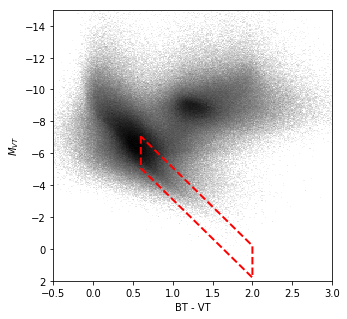

In [25]:
from mrspoc import get_table_ms
from astropy.constants import R_sun
import astropy.units as u

fig, ax = plt.subplots(figsize=(5, 5))
table = get_table_ms(ax=ax, plot=True)
fig.savefig('plots/hr.pdf', bbox_inches='tight')

In [26]:
table['R_star'] = table['R_star'].to(R_sun)

In [27]:
superflare_teff = 3200 # estimate for sptype = M4
#R_superflare = 0.116 # (Mathur+, 2017) 

# Compute the apparent angular jitter due to sunspots at the
# distances of nearby MS stars in the TGAS sample
distances = table['distance']
#R_star = bv_to_radius(table['B-V'].data.data)
R_star = table['R_star']
jitter_rstar = max_photocenter_shift * R_star
sigma_jitter = np.arctan((jitter_rstar.quantity/distances.quantity).decompose()).to(u.uarcsec)

# Estimate the single-measurement astrometric error for each star
# in the TGAS sample: 
sigma_gaia = table['sigma_fov']/np.sqrt(table['N_fov'])

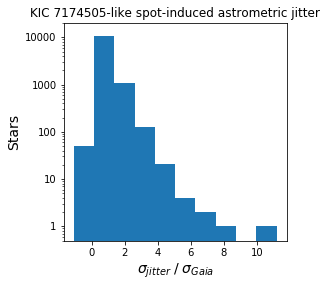

In [38]:
fig, ax = plt.subplots(figsize=(4, 4))

np.save('kic7174505_sn.npy', (sigma_jitter.value/sigma_gaia.data.data))

ax.hist(sigma_jitter/sigma_gaia, log=True, histtype='stepfilled')
ax.set_title('KIC 7174505-like spot-induced astrometric jitter')
ax.set_ylabel('Stars', fontsize=14)
ax.set_xlabel('$\sigma_{jitter} \; / \; \sigma_{Gaia}$', fontsize=14)
ax.set_ylim([0.5, 2e4])
y = [1, 10, 100, 1000, 1e4]
ax.set_yticks(y)
ax.set_yticklabels(["{0:g}".format(i) for i in y])
fig.savefig('plots/KIC7174505_jitter.pdf', bbox_inches='tight')

In [10]:
from astropy.table import Column, join

sig_jit = 'sigma_jitter'
sig_g = 'sigma_gaia'
snr = 'snr'
if sig_jit not in table.colnames:
    table.add_column(Column(data=sigma_jitter, name=sig_jit))
if sig_g not in table.colnames:
    table.add_column(Column(data=sigma_gaia, name=sig_g))
if snr not in table.colnames:
    table.add_column(Column(data=(sigma_jitter/sigma_gaia).decompose(), name=snr))

snr_gtr20 = table[table['snr'] > 5]
print("N stars:", np.count_nonzero(snr_gtr20))

N stars: 9


In [11]:
from astroquery.simbad import Simbad

sp_types = []
main_id = []
for hip_number in snr_gtr20['HIP']:
    customSimbad = Simbad()
    customSimbad.add_votable_fields('sptype')
    query = customSimbad.query_object("HIP {0}".format(hip_number))
    sp_types.append(query['SP_TYPE'][0])
    main_id.append(query['MAIN_ID'][0])

In [12]:
sptype_colname = 'Sp Type'
mainid_colname = 'main_id'

if not sptype_colname in snr_gtr20.colnames:
    snr_gtr20.add_column(Column(data=sp_types, name=sptype_colname))

if not mainid_colname in snr_gtr20.colnames:
    snr_gtr20.add_column(Column(data=main_id, name=mainid_colname))

### Activity cycle

In [13]:
from scipy.stats import anderson_ksamp, ks_2samp
from astropy.utils.console import ProgressBar

n_realizations = 1000

anderson_matrix = np.zeros((len(snr_gtr20), n_realizations))
ks_matrix = np.zeros((len(snr_gtr20), n_realizations))

with ProgressBar(n_realizations, ipython_widget=True) as bar:
    for i in range(n_realizations):
        # Observe the star N_fov times at minimum
        activity_minimum = [np.random.normal(loc=0, scale=sigma_fov, size=int(N_fov)) 
                             for sigma_fov, N_fov in 
                             zip(snr_gtr20['sigma_fov'].to(u.uarcsec).value, 
                                 snr_gtr20['N_fov'])]

        # Observe the star N_fov times at maximum
        activity_maximum = [np.random.normal(loc=0, scale=np.sqrt(sigma_fov**2 + sigma_jitter**2), size=int(N_fov)) 
                            for sigma_fov, sigma_jitter, N_fov in 
                            zip(snr_gtr20['sigma_fov'].to(u.uarcsec).value, 
                                snr_gtr20['sigma_jitter'], 
                                snr_gtr20['N_fov'])]

        # Compute the significance between position distributions activity minimum and maximum
        anderson = np.array([anderson_ksamp([minimum, maximum]).significance_level 
                             for minimum, maximum in zip(activity_minimum, activity_maximum)])
        ks = np.array([ks_2samp(minimum, maximum).pvalue
                       for minimum, maximum in zip(activity_minimum, activity_maximum)])

        anderson_matrix[:, i] = anderson
        ks_matrix[:, i] = ks
        bar.update()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


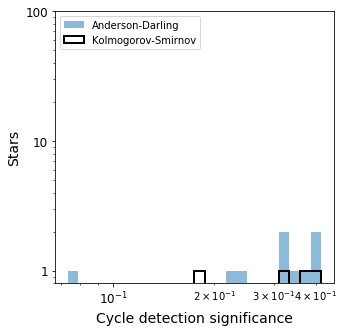

In [14]:
nbins = 25
log = True

fig, ax = plt.subplots(figsize=(5, 5))
MIN = anderson_matrix.mean(1).min()
MAX = anderson_matrix.mean(1).max()
bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), nbins)
ax.hist(anderson_matrix.mean(1), bins=bins, log=log, 
        label='Anderson-Darling', alpha=0.5, histtype='stepfilled')
ax.hist(ks_matrix.mean(1), bins=bins, histtype='step', 
        color='k', lw=2, log=log, label='Kolmogorov-Smirnov')
ax.set_xscale("log")
ax.legend(loc='upper left')
ax.set_xlabel('Cycle detection significance', fontsize=14)
ax.set_ylabel('Stars', fontsize=14)
ax.set_yticks([1, 10, 100])
ax.set_yticklabels([1, 10, 100])

plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)

ax.set_ylim([0.8, 100])
fig.savefig('plots/cycle.pdf', bbox_inches='tight')

In [15]:
pvalue_colname = 'ks'

c1 = Column(data=ks_matrix.mean(1), name=pvalue_colname)

if not pvalue_colname in snr_gtr20.colnames:    
    snr_gtr20.add_column(c1)
else: 
    snr_gtr20[pvalue_colname] = c1
    
anderson_colname = 'anderson'

c2 = Column(data=anderson_matrix.mean(1), name=anderson_colname)

if not pvalue_colname in snr_gtr20.colnames:
    snr_gtr20.add_column(c2)
else: 
    snr_gtr20[anderson_colname] = c2

In [16]:
latex_table = snr_gtr20[[mainid_colname,  'HIP', sptype_colname, 'R_star', 'rstar_ref','<Gmag>', 
                         'distance', 'N_fov', 'sigma_jitter', 'snr', 'ks', 'anderson']]
latex_table.sort('snr')
latex_table = latex_table[::-1]
from astropy.io import ascii

ascii.write(latex_table, format='latex', output='candidates.tex', 
            formats={'R_star': '0.3f', 'distance': '0.2f',
                     'N_fov': '0.1f', 'sigma_jitter': '0.1f', 'snr': '0.1f', 
                     'ks': '0.2g', 'anderson': '0.2g'})

In [17]:
!cat candidates.tex

\begin{table}
\begin{tabular}{cccccccccccc}
main_id & HIP & Sp Type & R_star & rstar_ref & <Gmag> & distance & N_fov & sigma_jitter & snr & ks & anderson \\
 &  &  & $\mathrm{6.957 \times 10^{8}\,m}$ &  &  & $\mathrm{pc}$ &  & $\mathrm{\mu arcsec}$ & $\mathrm{}$ &  &  \\
V* AX Mic & 105090 & M1V & 0.589 & 1.0 & 5.881 & 3.98 & 107.4 & 37.0 & 11.2 & 0.18 & 0.073 \\
* sig Dra & 96100 & K0V & 0.789 & 1.0 & 4.711 & 5.76 & 58.5 & 34.3 & 7.7 & 0.33 & 0.22 \\
V* GX And & 1475 & M2V & 0.459 & 2.0 & 7.096 & 3.56 & 55.6 & 32.3 & 7.0 & 0.36 & 0.25 \\
HD  79211 & 120005 & M0V & 0.572 & 2.0 & 6.948 & 6.29 & 107.4 & 22.8 & 6.9 & 0.41 & 0.32 \\
* p Eri & 7751 & K2V+K2V & 0.787 & 1.0 & 5.581 & 8.10 & 76.2 & 24.3 & 6.2 & 0.42 & 0.33 \\
LHS  3531 & 99701 & M0V & 0.564 & 1.0 & 7.134 & 6.16 & 69.1 & 22.9 & 5.6 & 0.44 & 0.35 \\
HD 222237 & 116745 & K3+V & 0.772 & 1.0 & 6.669 & 11.39 & 107.4 & 17.0 & 5.1 & 0.46 & 0.4 \\
HD  36395 & 25878 & M1.5Ve & 0.531 & 2.0 & 6.986 & 5.65 & 55.6 & 23.6 & 5.1 & 0.46 & 0.38

In [ ]:
# plt.hist(anderson_matrix.mean(1), bins=10, label='Anderson-Darling', alpha=0.5)